# IMDB Sentiment — LSTM vs Transformer (Fast Edition, Keras Datasets)

This is a **faster** version of the IMDB comparison. **subsample** the dataset and slightly **reduce model sizes** / **sequence length** so it runs quickly for learning purposes, while keeping the regular evaluation flow (accuracy, F1, etc.) for an educational purpose.

**Goal:** Compare **LSTM** and a lightweight **Transformer encoder** on **IMDB movie review sentiment**, using only `keras.datasets.imdb`. Keep the workflow leadership-ready: accuracy, F1, balanced accuracy, Cohen’s κ, MCC, log loss, learning curves, confusion matrix, parameter counts, and latency.

**Dataset:** `keras.datasets.imdb` returns train/test splits of integer-encoded reviews with a constrained vocabulary. Control `num_words` and `maxlen` to stress longer context.

## Setup

In [ ]:
import sys, time, json, numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, log_loss
)
from sklearn.model_selection import train_test_split

np.random.seed(7)
tf.random.set_seed(7)
warnings.filterwarnings("ignore")

print("Python:", sys.version.split()[0])
print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)


Python: 3.13.7
TensorFlow: 2.20.0
NumPy: 2.3.2
Pandas: 2.3.2



## Load & Subsample IMDB from `keras.datasets`

Use a **subset** of the official train/test splits to reduce training time. Adjust the knobs below to balance speed vs. fidelity.


In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Speed knobs
NUM_WORDS = 5000   # smaller vocab than full
MAXLEN    = 600     # shorter sequences
TRAIN_FRACTION = 0.5   # use 50% of training split before making a val split
VAL_FRACTION   = 0.2   # 20% of (subsampled) train becomes validation
TEST_FRACTION  = 0.5   # use 50% of test split

BATCH_SIZE = 128
EPOCHS = 6
PATIENCE = 2

print("Loading IMDB (Keras) …")
(X_train_full, y_train_full), (X_test_full, y_test_full) = imdb.load_data(num_words=NUM_WORDS)
print("Full:", len(X_train_full), "train,", len(X_test_full), "test")

# Subsample train and test
rng = np.random.default_rng(7)
def subsample(X, y, frac):
    n = int(len(X) * frac)
    idx = rng.choice(len(X), size=n, replace=False)
    return [X[i] for i in idx], [int(y[i]) for i in idx]

X_train_sub, y_train_sub = subsample(X_train_full, y_train_full, TRAIN_FRACTION)
X_test_sub,  y_test_sub  = subsample(X_test_full,  y_test_full,  TEST_FRACTION)

# Make a validation split from the subsampled training portion
X_tr_idx, X_val_idx, y_tr, y_val = train_test_split(
    X_train_sub, y_train_sub, test_size=VAL_FRACTION, stratify=y_train_sub, random_state=7
)

def to_padded(x_list, maxlen=MAXLEN):
    return pad_sequences(x_list, maxlen=maxlen, truncating="post", padding="post")

X_tr  = to_padded(X_tr_idx, MAXLEN)
X_val = to_padded(X_val_idx, MAXLEN)
X_te  = to_padded(X_test_sub, MAXLEN)

y_tr = np.array(y_tr, dtype=np.int32)
y_val = np.array(y_val, dtype=np.int32)
y_te  = np.array(y_test_sub, dtype=np.int32)

print("Shapes:", X_tr.shape, X_val.shape, X_te.shape)
print("Avg length (pre-pad) train sample:", np.mean([len(x) for x in X_tr_idx]))

Loading IMDB (Keras) …
Full: 25000 train, 25000 test
Shapes: (10000, 600) (2500, 600) (12500, 600)
Avg length (pre-pad) train sample: 238.344


## Models (slightly smaller for speed)


In [ ]:
EMB_DIM = 128
LSTM_UNITS = 96
TR_D_MODEL = 96
TR_DEPTH   = 2
TR_HEADS   = 4
TR_KEYDIM  = 24
TR_FFDIM   = 192
DROPOUT    = 0.25

def build_lstm_model(vocab_size, seq_len, emb_dim=EMB_DIM, units=LSTM_UNITS, dropout=DROPOUT):
    inp = layers.Input(shape=(seq_len,), dtype=tf.int32)
    x = layers.Embedding(vocab_size, emb_dim, mask_zero=True)(inp)
    x = layers.Bidirectional(layers.LSTM(units))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(96, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
    return model

def positional_encoding_sincos(length, d_model):
    positions = np.arange(length)[:, None]
    div_terms = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe = np.zeros((length, d_model), dtype=np.float32)
    pe[:, 0::2] = np.sin(positions * div_terms)
    pe[:, 1::2] = np.cos(positions * div_terms)
    return tf.constant(pe[None, ...])

class AddPositionalEncoding(layers.Layer):
    def __init__(self, length, d_model, **kwargs):
        super().__init__(**kwargs)
        self.pe = positional_encoding_sincos(length, d_model)
    def call(self, x):
        return x + self.pe[:, :tf.shape(x)[1], :]

def transformer_encoder_block(x, num_heads=TR_HEADS, key_dim=TR_KEYDIM, ff_dim=TR_FFDIM, dropout=DROPOUT):
    h = layers.LayerNormalization()(x)
    h = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout)(h, h)
    h = layers.Dropout(dropout)(h)
    x = layers.Add()([x, h])
    h2 = layers.LayerNormalization()(x)
    h2 = layers.Dense(ff_dim, activation="gelu")(h2)
    h2 = layers.Dropout(dropout)(h2)
    h2 = layers.Dense(x.shape[-1])(h2)
    h2 = layers.Dropout(dropout)(h2)
    x = layers.Add()([x, h2])
    return x

def build_transformer_model(vocab_size, seq_len, d_model=TR_D_MODEL, depth=TR_DEPTH, heads=TR_HEADS, key_dim=TR_KEYDIM, ff_dim=TR_FFDIM, dropout=DROPOUT):
    inp = layers.Input(shape=(seq_len,), dtype=tf.int32)
    x = layers.Embedding(vocab_size, d_model, mask_zero=True)(inp)
    x = AddPositionalEncoding(seq_len, d_model)(x)
    for _ in range(depth):
        x = transformer_encoder_block(x, num_heads=heads, key_dim=key_dim, ff_dim=ff_dim, dropout=dropout)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(96, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
    return model

## Train

In [ ]:
print("Training LSTM…")
lstm = build_lstm_model(NUM_WORDS, MAXLEN)
hist_lstm = lstm.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
lstm_test_loss, lstm_test_acc = lstm.evaluate(X_te, y_te, verbose=0)

print("Training Transformer…")
trf = build_transformer_model(NUM_WORDS, MAXLEN)
hist_trf = trf.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
trf_test_loss, trf_test_acc = trf.evaluate(X_te, y_te, verbose=0)

import pandas as pd
results = [
    {"model": "LSTM", "test_acc": float(lstm_test_acc), "params": lstm.count_params()},
    {"model": "Transformer", "test_acc": float(trf_test_acc), "params": trf.count_params()}
]
res_df = pd.DataFrame(results).sort_values("test_acc", ascending=False).reset_index(drop=True)
display(res_df)

Training LSTM…
Epoch 1/6
79/79 - 38s - 481ms/step - accuracy: 0.6452 - loss: 0.6430 - val_accuracy: 0.7852 - val_loss: 0.4445
Epoch 2/6
79/79 - 40s - 506ms/step - accuracy: 0.8582 - loss: 0.3314 - val_accuracy: 0.8604 - val_loss: 0.3297
Epoch 3/6
79/79 - 38s - 479ms/step - accuracy: 0.9215 - loss: 0.2081 - val_accuracy: 0.8564 - val_loss: 0.3981
Epoch 4/6
79/79 - 38s - 478ms/step - accuracy: 0.9359 - loss: 0.1654 - val_accuracy: 0.8656 - val_loss: 0.4006
Epoch 5/6
79/79 - 38s - 487ms/step - accuracy: 0.9446 - loss: 0.1417 - val_accuracy: 0.8396 - val_loss: 0.5839
Epoch 6/6
79/79 - 39s - 500ms/step - accuracy: 0.9519 - loss: 0.1219 - val_accuracy: 0.8368 - val_loss: 0.5137
Training Transformer…
Epoch 1/6


/Users/xtra-moon2472/PythonProjects/Git/ust-mail/.venv/lib/python3.13/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'add_positional_encoding' (of type AddPositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


79/79 - 150s - 2s/step - accuracy: 0.4986 - loss: 0.7042 - val_accuracy: 0.4996 - val_loss: 0.6950
Epoch 2/6
79/79 - 146s - 2s/step - accuracy: 0.5108 - loss: 0.6981 - val_accuracy: 0.5012 - val_loss: 0.6931
Epoch 3/6
79/79 - 147s - 2s/step - accuracy: 0.5872 - loss: 0.6572 - val_accuracy: 0.7596 - val_loss: 0.5200
Epoch 4/6
79/79 - 145s - 2s/step - accuracy: 0.8151 - loss: 0.4151 - val_accuracy: 0.8280 - val_loss: 0.4044
Epoch 5/6
79/79 - 145s - 2s/step - accuracy: 0.8905 - loss: 0.2739 - val_accuracy: 0.8532 - val_loss: 0.3605
Epoch 6/6
79/79 - 145s - 2s/step - accuracy: 0.9262 - loss: 0.1968 - val_accuracy: 0.8696 - val_loss: 0.3991


,model,test_acc,params
0,Transformer,0.8536,638977
1,LSTM,0.8392,831425


## Learning curves & capacity vs accuracy


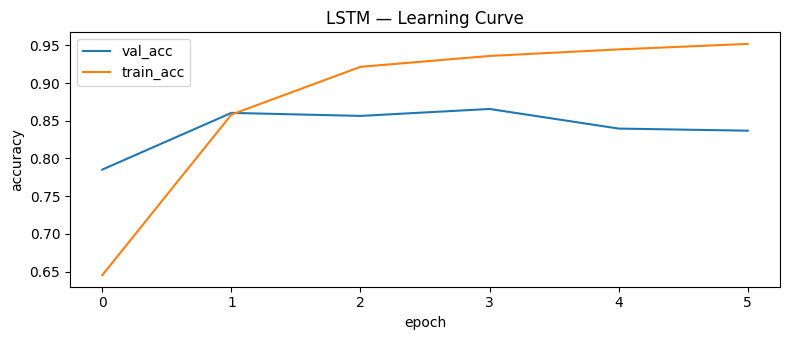

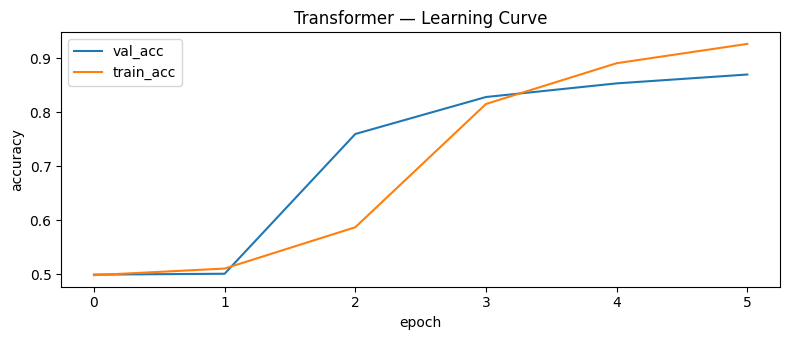

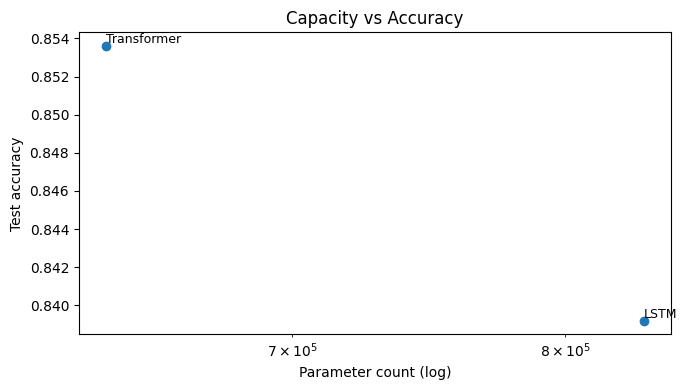

In [ ]:
def plot_learning_curve(hist, title):
    plt.figure(figsize=(8,3.5))
    plt.plot(hist.history["val_accuracy"], label="val_acc")
    plt.plot(hist.history["accuracy"], label="train_acc")
    plt.title(title); plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.tight_layout(); plt.show()

plot_learning_curve(hist_lstm, "LSTM — Learning Curve")
plot_learning_curve(hist_trf, "Transformer — Learning Curve")

plt.figure(figsize=(7,4))
plt.scatter(res_df["params"], res_df["test_acc"])
for i, r in res_df.iterrows():
    plt.text(r["params"], r["test_acc"], r["model"], fontsize=9, ha="left", va="bottom")
plt.xscale("log")
plt.xlabel("Parameter count (log)"); plt.ylabel("Test accuracy"); plt.title("Capacity vs Accuracy"); plt.tight_layout(); plt.show()

## Rich metrics & confusion matrices


LSTM metrics:
              precision    recall  f1-score   support

         neg       0.85      0.83      0.84      6257
         pos       0.83      0.85      0.84      6243

    accuracy                           0.84     12500
   macro avg       0.84      0.84      0.84     12500
weighted avg       0.84      0.84      0.84     12500



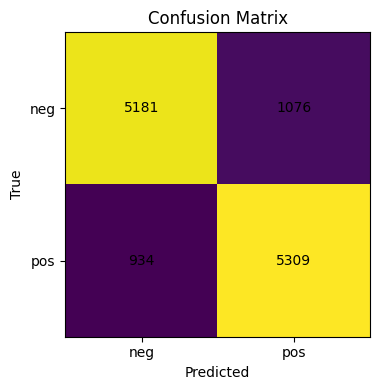


Transformer metrics:


/Users/xtra-moon2472/PythonProjects/Git/ust-mail/.venv/lib/python3.13/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'add_positional_encoding' (of type AddPositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


              precision    recall  f1-score   support

         neg       0.89      0.81      0.85      6257
         pos       0.83      0.90      0.86      6243

    accuracy                           0.85     12500
   macro avg       0.86      0.85      0.85     12500
weighted avg       0.86      0.85      0.85     12500



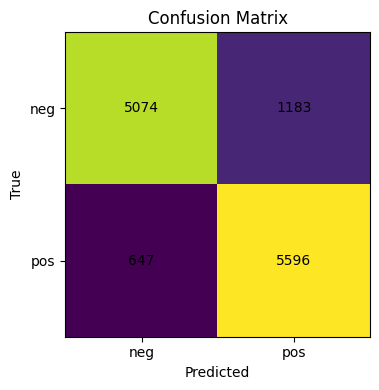

,accuracy,balanced_accuracy,precision,recall,f1,cohen_kappa,mcc,log_loss
model,,,,,,,,
LSTM,0.8392,0.839213,0.83148,0.850392,0.840830,0.678408,0.678583,0.515598
Transformer,0.8536,0.853648,0.82549,0.896364,0.859469,0.707228,0.709842,0.422821


In [ ]:
def evaluate_model_bin(model, X, y_true):
    prob = model.predict(X, batch_size=256, verbose=0).ravel()
    y_pred = (prob >= 0.5).astype(int)
    out = {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred),
        "cohen_kappa": cohen_kappa_score(y_true, y_pred),
        "mcc": matthews_corrcoef(y_true, y_pred),
        "log_loss": log_loss(y_true, np.clip(prob, 1e-7, 1-1e-7))
    }
    print(classification_report(y_true, y_pred, target_names=["neg","pos"]))
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["neg","pos"]); ax.set_yticklabels(["neg","pos"])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=10)
    plt.tight_layout(); plt.show()
    return out

print("LSTM metrics:")
lstm_metrics = evaluate_model_bin(lstm, X_te, y_te)
print("\nTransformer metrics:")
trf_metrics = evaluate_model_bin(trf, X_te, y_te)

metrics_df = pd.DataFrame([{"model":"LSTM", **lstm_metrics},{"model":"Transformer", **trf_metrics}]).set_index("model")
display(metrics_df)

## Practicality: inference latency


In [ ]:
def benchmark_inference(model, X, batch_sizes=[1, 32, 128, 512]):
    rows = []
    for b in batch_sizes:
        _ = model.predict(X[:b], verbose=0)  # warmup
        t0 = time.time()
        _ = model.predict(X[:b], verbose=0)
        t1 = time.time()
        rows.append({"batch": b, "ms_per_batch": (t1 - t0)*1000.0})
    return pd.DataFrame(rows)

print("LSTM latency:")
lat_lstm = benchmark_inference(lstm, X_te)
print(lat_lstm)

print("\nTransformer latency:")
lat_trf = benchmark_inference(trf, X_te)
print(lat_trf)

LSTM latency:
   batch  ms_per_batch
0      1     48.196077
1     32     66.977978
2    128    228.095055
3    512    960.420847

Transformer latency:
   batch  ms_per_batch
0      1     32.068968
1     32    173.141956
2    128    655.718088
3    512   2553.084850
